In [1]:
!pip install fsspec

    100% |████████████████████████████████| 71kB 188kB/s 


https://stackoverflow.com/questions/45545110/how-do-you-parallelize-apply-on-pandas-dataframes-making-use-of-all-cores-on-o/45545111

In [2]:
!pip install dask distributed --upgrade

    100% |████████████████████████████████| 808kB 518kB/s 
    100% |████████████████████████████████| 634kB 568kB/s 
    100% |████████████████████████████████| 450kB 217kB/s 
    100% |████████████████████████████████| 276kB 990kB/s 
    100% |████████████████████████████████| 92kB 860kB/s 
  Running setup.py bdist_wheel for psutil ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/d7/69/b4/3200b95828d1f0ddb3cb5699083717f4fdbd9b4223d0644c57
Successfully built psutil
  Found existing installation: dask 0.20.2
    Uninstalling dask-0.20.2:
      Successfully uninstalled dask-0.20.2


In [3]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:43853 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.09 GB


In [4]:
import time
import pickle
import matplotlib.pyplot as plt
import pandas
print('pandas',pandas.__version__)
import numpy
print('numpy',numpy.__version__)
import dask.dataframe as dd
from dask.multiprocessing import get

pandas 0.23.4
numpy 1.13.3


In [5]:
df = pandas.DataFrame(
    numpy.random.randint(0,1000,size=(1000, 4)), 
    columns=list('ABCD')
    )
print(df.shape)
df.head()

(1000, 4)


,A,B,C,D
0,927,316,193,619
1,173,710,824,395
2,605,22,4,906
3,973,693,954,545
4,805,623,42,797


In [6]:
ddata = dd.from_pandas(df, npartitions=4)

In [7]:
def double_col_a(row):
    row_as_dict=dict(row)
    return row_as_dict['A']*2

options for scheduler are 'single-threaded','threads','processes'

The threaded scheduler executes computations with a local `multiprocessing.pool.ThreadPool`.

See https://docs.dask.org/en/latest/scheduling.html

In [8]:
# https://stackoverflow.com/questions/45545110/how-do-you-parallelize-apply-on-pandas-dataframes-making-use-of-all-cores-on-o/45545111
start_time = time.time()
res = ddata.map_partitions(lambda df: df.apply(
    (lambda row: double_col_a(row)), axis=1)).compute(scheduler='threads')
print(time.time() - start_time)

1.7441322803497314


In [9]:
with open('multiprocessing_data.pkl','rb') as f: 
    serial_reslts, pool_reslts, lambda_reslts = pickle.load(f)

In [10]:
serial_reslts

{100: 0.01564290523529053,
 1000: 0.13357844352722167,
 10000: 1.9118867635726928,
 100000: 12.924072241783142}

In [11]:
pool_reslts

{100: 0.1539085626602173,
 1000: 0.15258731842041015,
 10000: 0.8222435235977172,
 100000: 7.081635594367981}

In [12]:
number_of_tests=10
list_of_row_size=list(pool_reslts.keys())

In [13]:
dask_threads_reslts={}
scaling_start=time.time()
for row_count in list_of_row_size:
    test_reslts=[]
    for test_indx in range(number_of_tests):
        df = pandas.DataFrame(numpy.random.randint(0,1000,size=(row_count, 4)), columns=list('ABCD'))
        start_time = time.time()
        ddata = dd.from_pandas(df, npartitions=4)
        res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).compute(scheduler='threads')
        test_reslts.append(time.time() - start_time)
    dask_threads_reslts[row_count]=sum(test_reslts)/number_of_tests
    print('elapsed time:',time.time() - scaling_start,'for',row_count)

elapsed time: 2.6790661811828613 for 100
elapsed time: 8.009647607803345 for 1000
elapsed time: 52.404067516326904 for 10000
elapsed time: 453.8834857940674 for 100000


In [14]:
dask_processes_reslts={}
scaling_start=time.time()
for row_count in list_of_row_size:
    test_reslts=[]
    for test_indx in range(number_of_tests):
        df = pandas.DataFrame(numpy.random.randint(0,1000,size=(row_count, 4)), columns=list('ABCD'))
        start_time = time.time()
        ddata = dd.from_pandas(df, npartitions=4)
        res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).compute(scheduler='processes')
        test_reslts.append(time.time() - start_time)
    dask_processes_reslts[row_count]=sum(test_reslts)/number_of_tests
    print('elapsed time:',time.time() - scaling_start,'for',row_count)

elapsed time: 3.3385326862335205 for 100
elapsed time: 7.2331976890563965 for 1000
elapsed time: 26.50709366798401 for 10000
elapsed time: 217.88823199272156 for 100000


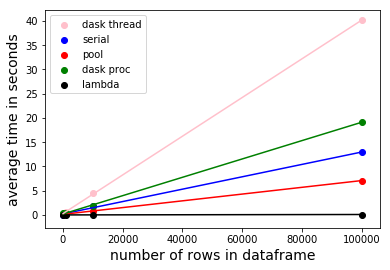

In [15]:
serial_x = list(serial_reslts.keys()) # list_of_row_size
serial_y = list(serial_reslts.values())

pool_x = list(pool_reslts.keys()) # list_of_row_size
pool_y = list(pool_reslts.values())

lambda_x = list(lambda_reslts.keys()) # list_of_row_size
lambda_y = list(lambda_reslts.values())

dask_processes_x = list(dask_processes_reslts.keys()) # list_of_row_size
dask_processes_y = list(dask_processes_reslts.values())

dask_threads_x = list(dask_threads_reslts.keys()) # list_of_row_size
dask_threads_y = list(dask_threads_reslts.values())


_=plt.scatter(dask_threads_x,dask_threads_y,color='pink',label='dask thread')
_=plt.scatter(serial_x,serial_y,color='blue',label='serial')
_=plt.scatter(pool_x,pool_y,color='red',label='pool')
_=plt.scatter(dask_processes_x,dask_processes_y,color='green',label='dask proc')
_=plt.scatter(lambda_x,lambda_y,color='black',label='lambda')
_=plt.ylabel('average time in seconds',fontsize=14)
_=plt.xlabel('number of rows in dataframe',fontsize=14)
_=plt.plot(numpy.unique(serial_x), numpy.poly1d(numpy.polyfit(serial_x, serial_y, 1))(numpy.unique(serial_x)),color='blue') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(pool_x), numpy.poly1d(numpy.polyfit(pool_x, pool_y, 1))(numpy.unique(pool_x)),color='red') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(lambda_x), numpy.poly1d(numpy.polyfit(lambda_x, lambda_y, 1))(numpy.unique(lambda_x)),color='black') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(dask_processes_x), numpy.poly1d(numpy.polyfit(dask_processes_x, dask_processes_y, 1))(numpy.unique(dask_processes_x)),color='green') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(dask_threads_x), numpy.poly1d(numpy.polyfit(dask_threads_x, dask_threads_y, 1))(numpy.unique(dask_threads_x)),color='pink') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python

ax = plt.gca()
_=ax.legend()
#ax.grid(True)

Dask vs multiprocessing:
https://github.com/dask/dask/issues/1783

There are additional libraries built on top of Dask,<BR>

https://github.com/jmcarpenter2/swifter
https://github.com/jmcarpenter2/swifter/blob/master/examples/swifter_apply_examples.ipynb
https://github.com/jmcarpenter2/swifter/blob/master/examples/swiftapply_speedcomparison.ipynb

Ignore the rest of these cells

# Dask dashboard
    
https://docs.dask.org/en/latest/diagnostics-distributed.html

In [16]:
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard

#client = Client(threads_per_worker=20, n_workers=1)
client

/opt/conda/lib/python3.6/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43457 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:44159 Dashboard: http://127.0.0.1:43457/status,Cluster Workers: 4 Cores: 4 Memory: 2.09 GB


see http://localhost:8787/status

(If running in Docker, you'd need to have that port exposed)

# Profiling

https://docs.dask.org/en/latest/diagnostics-local.html

In [17]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler

In [18]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof,CacheProfiler() as cprof:
    res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).compute(scheduler='processes')

In [19]:
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

bokeh.models.layouts.Column(
    id='12909734-a7c9-4d05-9d19-4f7214117d05',
    children=[bokeh.models.tools.ToolbarBox(
         id='c8bb4d1c-259e-431c-b0e7-cadacbfcd003',
         css_classes=[],
         disabled=False,
         height=None,
         js_event_callbacks={},
         js_property_callbacks={},
         name=None,
         sizing_mode='fixed',
         subscribed_events=[],
         tags=[],
         toolbar=bokeh.models.tools.ProxyToolbar(
             id='d0ac117b-5bf9-4731-87fc-62ac99422994',
             js_event_callbacks={},
             js_property_callbacks={},
             logo='normal',
             name=None,
             subscribed_events=[],
             tags=[],
             tools=[bokeh.models.tools.HoverTool(
                  id='9cd8a7f4-253c-442d-a5c1-cfd19208282f',
                  anchor='center',
                  attachment='horizontal',
                  callback=None,
                  formatters={},
                  js_event_callbacks={},
                  js_property_callbacks={},
                  line_policy='nearest',
                  mode='mouse',
                  name=None,
                  names=[],
                  point_policy='follow_mouse',
                  renderers='auto',
                  show_arrow=True,
                  subscribed_events=[],
                  tags=[],
                  toggleable=True,
                  tooltips='\n    <div>\n        <span style="font-size: 14px; font-weight: bold;">Key:</span>&nbsp;\n        <span style="font-size: 10px; font-family: Monaco, monospace;">@key</span>\n    </div>\n    <div>\n        <span style="font-size: 14px; font-weight: bold;">Task:</span>&nbsp;\n        <span style="font-size: 10px; font-family: Monaco, monospace;">@function</span>\n    </div>\n    '),
              bokeh.models.tools.SaveTool(
                  id='6acc2c9b-cf5d-4a5a-8ef6-24b1a055a238',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.ResetTool(
                  id='9d5ea453-1f94-4b6c-b0df-d9d0532a778a',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.WheelZoomTool(
                  id='938613b0-6784-4dbb-965e-097976090ccb',
                  dimensions='width',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  maintain_focus=True,
                  name=None,
                  speed=0.0016666666666666668,
                  subscribed_events=[],
                  tags=[],
                  zoom_on_axis=True),
              bokeh.models.tools.PanTool(
                  id='3f55fe77-0224-495b-9957-ba589fb42a24',
                  dimensions='width',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.SaveTool(
                  id='f073df6a-6d3f-4d0d-9f20-902d73089883',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.ResetTool(
                  id='70e25d85-7576-4006-bf7d-6268e0819372',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.WheelZoomTool(
                  id='16bfbf71-5ffb-4d5c-aee8-b6468ebb54b1',
                  dimensions='width',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  maintain_focus=True,
     

In [20]:
prof.visualize()

bokeh.plotting.figure.Figure(
    id='52993462-3a7d-424e-9aa4-8038f1016062',
    above=[],
    aspect_scale=1,
    background_fill_alpha={'value': 1.0},
    background_fill_color={'value': '#ffffff'},
    below=[bokeh.models.axes.LinearAxis(
         id='bd5d7da0-d24a-4e80-989c-1e707a5d3450',
         axis_label='Time (s)',
         axis_label_standoff=5,
         axis_label_text_align='left',
         axis_label_text_alpha={'value': 1.0},
         axis_label_text_baseline='bottom',
         axis_label_text_color={'value': '#444444'},
         axis_label_text_font='helvetica',
         axis_label_text_font_size={'value': '10pt'},
         axis_label_text_font_style='italic',
         axis_label_text_line_height=1.2,
         axis_line_alpha={'value': 1.0},
         axis_line_cap='butt',
         axis_line_color={'value': None},
         axis_line_dash=[],
         axis_line_dash_offset=0,
         axis_line_join='bevel',
         axis_line_width={'value': 1},
         bounds='auto',
         fixed_location=None,
         formatter=bokeh.models.formatters.BasicTickFormatter(
             id='44b3f9f5-96fd-44c7-9e47-602378d79d72',
             js_event_callbacks={},
             js_property_callbacks={},
             name=None,
             power_limit_high=5,
             power_limit_low=-3,
             precision='auto',
             subscribed_events=[],
             tags=[],
             use_scientific=True),
         js_event_callbacks={},
         js_property_callbacks={},
         level='overlay',
         major_label_orientation='horizontal',
         major_label_overrides={},
         major_label_standoff=5,
         major_label_text_align='center',
         major_label_text_alpha={'value': 1.0},
         major_label_text_baseline='alphabetic',
         major_label_text_color={'value': '#444444'},
         major_label_text_font='helvetica',
         major_label_text_font_size={'value': '8pt'},
         major_label_text_font_style='normal',
         major_label_text_line_height=1.2,
         major_tick_in=2,
         major_tick_line_alpha={'value': 1.0},
         major_tick_line_cap='butt',
         major_tick_line_color={'value': None},
         major_tick_line_dash=[],
         major_tick_line_dash_offset=0,
         major_tick_line_join='bevel',
         major_tick_line_width={'value': 1},
         major_tick_out=6,
         minor_tick_in=0,
         minor_tick_line_alpha={'value': 1.0},
         minor_tick_line_cap='butt',
         minor_tick_line_color={'value': 'black'},
         minor_tick_line_dash=[],
         minor_tick_line_dash_offset=0,
         minor_tick_line_join='bevel',
         minor_tick_line_width={'value': 1},
         minor_tick_out=4,
         name=None,
         plot=bokeh.plotting.figure.Figure(id='52993462-3a7d-424e-9aa4-8038f1016062', ...),
         subscribed_events=[],
         tags=[],
         ticker=bokeh.models.tickers.BasicTicker(
             id='4963e095-a64b-40f0-8031-a011a7249ba4',
             base=10.0,
             desired_num_ticks=6,
             js_event_callbacks={},
             js_property_callbacks={},
             mantissas=[1, 2, 5],
             max_interval=None,
             min_interval=0.0,
             name=None,
             num_minor_ticks=5,
             subscribed_events=[],
             tags=[]),
         visible=True,
         x_range_name='default',
         y_range_name='default')],
    border_fill_alpha={'value': 1.0},
    border_fill_color={'value': '#ffffff'},
    css_classes=[],
    disabled=False,
    extra_x_ranges={},
    extra_y_ranges={},
    h_symmetry=True,
    height=None,
    hidpi=True,
    js_event_callbacks={},
    js_property_callbacks={},
    left=[bokeh.models.axes.CategoricalAxis(
         id='119544e2-2329-4ee9-865b-5735a2738aca',
         axis_label='Worker ID',
         axis_label_standoff=5,
         axis_label_text_align='left',
         axis_label_text_alpha={'value': 1.0},
         axis_label_text_baseline='bottom',
         axis_

In [21]:
!pip install graphviz

In [22]:
res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).visualize()

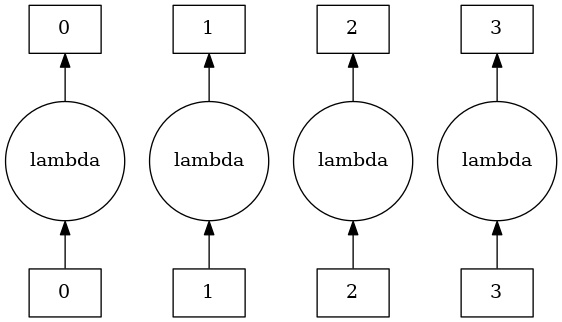

In [23]:
res